In [1]:
# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# load data
train_dir = "/kaggle/input/poultry/data_split/train/"
test_dir = "/kaggle/input/poultry/data_split/test/"
val_dir = "/kaggle/input/poultry/data_split/val/"

In [3]:
# model parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 3

In [4]:
# Data Augmentation for Training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.4,
    fill_mode='nearest'
)

# data aug for val and test set
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# load and configure datagens
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# class names
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")

Found 2945 images belonging to 3 classes.
Found 982 images belonging to 3 classes.
Found 982 images belonging to 3 classes.
Classes: ['coccidiosis', 'healthy', 'newcastle']


In [6]:
# define model
def create_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        include_top=False,
        weights='imagenet'
    )
    # freeze the basse layers of pretrained-model
    base_model.trainable = False

    # create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    # compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [7]:
# create model summary
model = create_model()
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# training callbacks
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('pdisease_detector.keras', verbose=1)
]

# calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8092 - loss: 0.5640
Epoch 1: saving model to pdisease_detector.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 60s 509ms/step - accuracy: 0.8098 - loss: 0.5620 - val_accuracy: 0.9302 - val_loss: 0.2018 - learning_rate: 0.0010
Epoch 2/100
 1/92 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8750 - loss: 0.2363

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to pdisease_detector.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8750 - loss: 0.2363 - val_accuracy: 0.9545 - val_loss: 0.1720 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9141 - loss: 0.2377
Epoch 3: saving model to pdisease_detector.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 333ms/step - accuracy: 0.9142 - loss: 0.2374 - val_accuracy: 0.9208 - val_loss: 0.2131 - learning_rate: 0.0010
Epoch 4/100
 1/92 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8750 - loss: 0.3863
Epoch 4: saving model to pdisease_detector.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8750 - loss: 0.3863 - val_accuracy: 1.0000 - val_loss: 0.0530 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9257 - loss: 0.1939
Epoch 5: saving model to pdisease_detector.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 333ms/step - accuracy: 0.9257 - loss: 0.1939 - val_accuracy: 0.9458 - val_loss: 0.1684 - le

In [10]:
# plot graphs
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12,8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')

    # save figures
    plt.savefig('poultry_disease_dectector_training_history.png')

    plt.show() # show plot

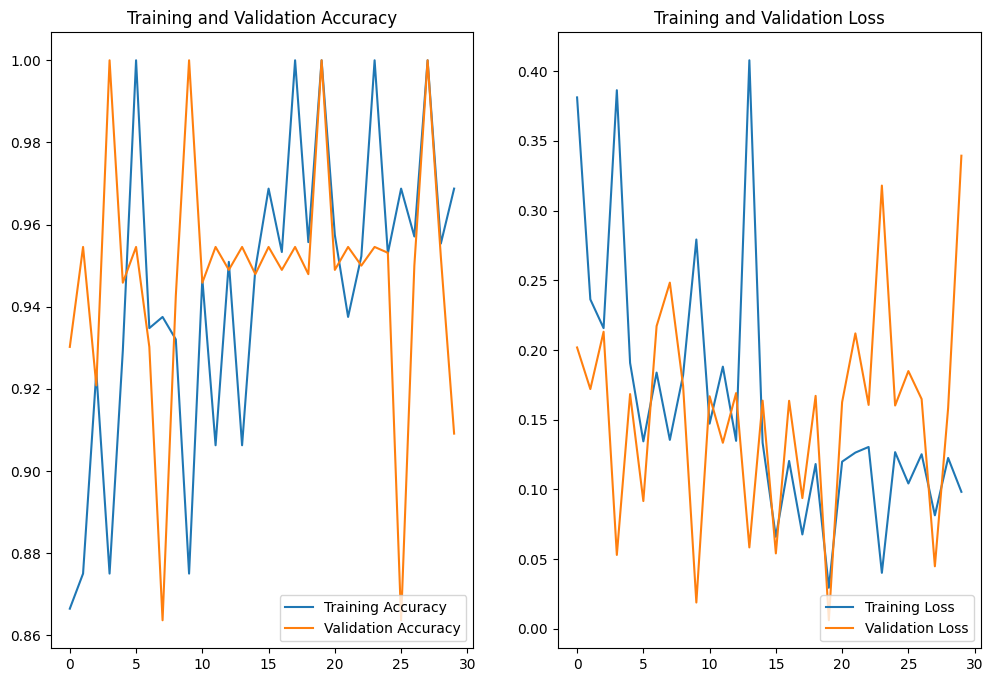

In [11]:
plot_training_history(history)

In [12]:
# evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9620 - loss: 0.0987
Test Accuracy: 0.9521


In [13]:
# predict an image
def predict_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])

    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.4f}")

    # show all class probabilities
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i]:.4f}")

    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]} ({confidence:.4f})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: coccidiosis
Confidence: 1.0000
coccidiosis: 1.0000
healthy: 0.0000
newcastle: 0.0000


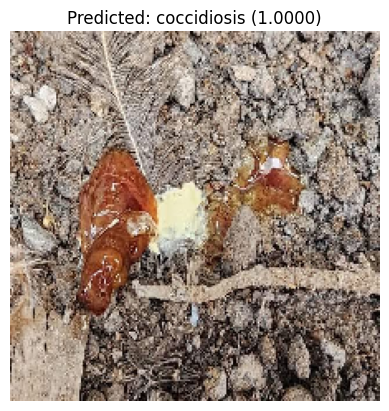

In [14]:
predict_image('/kaggle/input/test-image/IMG_2509.JPG')